In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

#imports

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers
from tensorflow.keras import activations
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import initializers
import datetime


# import 
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_DEPTH = 3
BATCH_SIZE = 128
NUM_SAMPLES = 202599

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - .5) / .5
    # resize the image to the desired size.
    return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img



def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
#     ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds



def data_generator():
    
    # DATA Preprocessing and Generator
    data_dir = 'data/img_align_celeba/*.jpg'
    list_ds = tf.data.Dataset.list_files(data_dir)

    processed_images = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return prepare_for_training(processed_images)
    

In [3]:
data_gen = data_generator()



In [4]:

# for image_batch in data_gen:
#     print(image_batch.shape)
#     print(image_batch[0].shape)
#     plt.imshow(image_batch[0])
#     break

# # plt.imshow(image)

In [5]:
def make_generator_model():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,), kernel_initializer=initializer))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=initializer))
    assert model.output_shape == (None, 64, 64, 3)
    model.add(layers.Activation('linear', dtype='float32'))
    

    return model

def make_generator_model_128():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,), kernel_initializer=initializer))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 16, 16, 512)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=initializer))
    assert model.output_shape == (None, 128, 128, 3)
    model.add(layers.Activation('linear', dtype='float32'))
    
    model.summary()
    return model

tf.Tensor(
[[[0.5003731  0.4991927  0.49957824]
  [0.49913168 0.5017824  0.49934053]
  [0.5015106  0.49826622 0.5014286 ]
  ...
  [0.49551773 0.50056887 0.5024204 ]
  [0.50209427 0.49841404 0.50129795]
  [0.49696732 0.50193024 0.5023613 ]]

 [[0.5008426  0.49995932 0.49848175]
  [0.49396515 0.49386597 0.5079346 ]
  [0.50450516 0.50013745 0.5048752 ]
  ...
  [0.4974785  0.5042572  0.5094452 ]
  [0.50523376 0.50375366 0.5003569 ]
  [0.5055237  0.5009494  0.509552  ]]

 [[0.50268745 0.50127506 0.49974823]
  [0.4978714  0.49783134 0.500437  ]
  [0.5058937  0.5005517  0.50024724]
  ...
  [0.49152374 0.49316788 0.50268555]
  [0.5048561  0.48809814 0.49798584]
  [0.49417114 0.49757004 0.5017605 ]]

 ...

 [[0.5035572  0.4979725  0.4990139 ]
  [0.48103333 0.5099869  0.50237656]
  [0.5017662  0.5056915  0.49981725]
  ...
  [0.5057831  0.48923492 0.50655746]
  [0.5070305  0.5145798  0.4908142 ]
  [0.5233917  0.49806213 0.5073929 ]]

 [[0.49959707 0.50274277 0.501029  ]
  [0.5054512  0.50484467 0

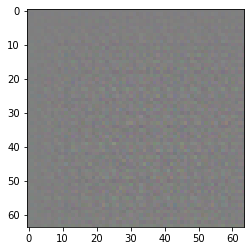

In [6]:
generator = make_generator_model()
# generator = make_generator_model_128()


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0] * .5 + .5))
print(generated_image[0] * .5 + .5)


In [7]:
def make_discriminator_model():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
    model.add(layers.GaussianNoise(0.2, input_shape = [64, 64, 3]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization( scale=False))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))



    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid', dtype='float32'))
#     model.add(layers.LeakyReLU(alpha =  0.2, dtype='float32'))
    return model

def make_discriminator_model_128():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
#     model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 3]))
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3], kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization( scale=False))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))



    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid', dtype='float32'))
#     model.add(layers.LeakyReLU(alpha =  0.2, dtype='float32'))
    model.summary()
    return model

In [8]:
discriminator = make_discriminator_model()
# discriminator = make_discriminator_model_128()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.50289536]], shape=(1, 1), dtype=float32)


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) #from_logits true if not using (0,1)

# TB Stuff
train_loss_G = tf.keras.metrics.Mean('train_loss_G', dtype=tf.float32)
train_loss_D = tf.keras.metrics.Mean('train_loss_G', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_D = 'logs/' + current_time+ 'train/D_loss'
train_log_dir_G = 'logs/' + current_time+ 'train/G_loss'
train_log_dir_PIC = 'logs/' + current_time+ 'train/pic'

train_summary_writer_D = tf.summary.create_file_writer(train_log_dir_D)
train_summary_writer_G = tf.summary.create_file_writer(train_log_dir_G)
train_summary_writer_PIC = tf.summary.create_file_writer(train_log_dir_PIC)




In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1=0.5)


In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [14]:
EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    train_disc = True

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        
#         TB Stuff
        train_loss_G(gen_loss)
        train_loss_D(disc_loss)
        if disc_loss < .3:
            train_disc = False
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    if train_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        
        
        results = generate_and_save_images(generator, epoch, seed)
        
        with train_summary_writer_D.as_default():
            tf.summary.scalar('loss', train_loss_D.result(), step=epoch)
        with train_summary_writer_G.as_default():
            tf.summary.scalar('loss', train_loss_G.result(), step=epoch)
        with train_summary_writer_PIC.as_default():
            name = "Epoch:" + str(epoch) + " Images"
            tf.summary.image(name, results, step=epoch, max_outputs = 4)

        
        train_loss_G.reset_states()
        train_loss_D.reset_states()

        # Produce images for the GIF as we go
        
#         display.clear_output(wait=True)
        
        

#         Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))




In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    predictions = predictions* 0.5 + 0.5 
    return predictions



In [18]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [ ]:
train(data_gen, EPOCHS)